In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os

In [3]:
%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [4]:
cnx = create_engine(os.getenv('EDMDB'))

#### PLUTO and building footprints comparison. Create supporting dataframes

Create dataframes of bldgclass and landuse definitions

In [25]:
bldgclass_def = pd.read_sql_query('''SELECT * FROM dcp.bldgclass_definitions;''', cnx)
landuse_def = pd.read_sql_query('''SELECT * FROM dcp.landuse_definitions;''', cnx)
landuse_def

,landuse,def
0,01,One and Two Family Buildings
1,02,Multi-Family Walkup Buildings
2,03,Multi-Family Elevator Buildings
3,04,Mixed Residential and Commercial
4,05,Commercial and Office
5,06,Industrial and Manufacturing
6,07,Transportation and Utility
7,08,Public Facilities and Institutions
8,09,Open Space and Outdoor Recreation
9,10,Parking Facilities


Find lots where building footprints does not have the same number of buildings as PLUTO.

In [35]:
df = pd.read_sql_query('''WITH footprints_count_by_bbl AS (
	SELECT mpluto_bbl,
	COUNT(*) AS bldg_footprints_count
	FROM dcp.bldg_footprints
	GROUP BY mpluto_bbl
)
SELECT CAST(bbl AS TEXT),
borough,
address, 
landuse,
bldgclass,
ownername,
numbldgs,
bldg_footprints_count, 
numbldgs - bldg_footprints_count AS difference
FROM dcp.pluto201, footprints_count_by_bbl
WHERE bbl = CAST(mpluto_bbl AS NUMERIC)
AND numbldgs <> bldg_footprints_count
ORDER BY difference DESC;''', cnx)
df.head()

,bbl,borough,address,landuse,bldgclass,ownername,numbldgs,bldg_footprints_count,difference
0,4163500400,QN,None,01,A8,"BREEZY POINT COOPERATIVE, INC",1861,59,1802
1,4163500300,QN,None,01,A8,BREEZY POINT COOPERA,795,21,774
2,4163400050,QN,1 ROCKAWAY POINT BLVD,01,A8,BREEZY POINT CO-OP,515,17,498
3,4142600001,QN,154-68 BROOKVILLE BOULEVARD,07,T1,PORT AUTHORITY OF NY AND NJ,422,5,417
4,2051410120,BX,2049 BARTOW AVENUE,03,D4,RIVERBAY CORPORATION,251,3,248


#### Questions

How many lots have differences in counts?

In [8]:
df.shape[0]

21008

How often does PLUTO have greater numbers?

In [12]:
more_bldgs_on_pluto = df[(df['numbldgs'] > df['bldg_footprints_count'])]
more_bldgs_on_pluto.shape[0]

20703

How often does building footprints have greater numbers?

In [13]:
more_bldgs_on_footprints = df[(df['numbldgs'] < df['bldg_footprints_count'])]
more_bldgs_on_footprints.shape[0]

305

Does the landuse code tell us anything interesting?

In [32]:
landuse_counts = df['landuse'].value_counts()
landuse_dist = pd.DataFrame({'landuse':landuse_counts.index, 'count':landuse_counts.values})
landuse_dist = pd.merge(landuse_dist, landuse_def, how='left', on=['landuse'])
landuse_dist

,landuse,count,def
0,01,16717,One and Two Family Buildings
1,02,2374,Multi-Family Walkup Buildings
2,04,778,Mixed Residential and Commercial
3,08,299,Public Facilities and Institutions
4,03,222,Multi-Family Elevator Buildings
5,05,186,Commercial and Office
6,06,134,Industrial and Manufacturing
7,07,124,Transportation and Utility
8,11,60,Vacant Land
9,09,51,Open Space and Outdoor Recreation


What about the building class?

In [34]:
bldgclass_counts = df['bldgclass'].str.slice(0, 1).value_counts()
bldgclass_dist = pd.DataFrame({'bldgclass':bldgclass_counts.index, 'count':bldgclass_counts.values})
bldgclass_dist = pd.merge(bldgclass_dist, bldgclass_def, how='left', on=['bldgclass'])
bldgclass_dist

,bldgclass,count,descr
0,A,10240,One Family Dwellings
1,B,6475,Two Family Dwellings
2,C,2139,Walk-Up Apartments
3,R,446,Condominiums
4,S,434,Residence - Multiple Use
5,D,242,Elevator Apartments
6,K,202,Store Buildings (Taxpayers Included)
7,M,124,Churches and Synagogues
8,G,100,Garages and Gasoline Stations
9,W,88,Educational Structures


In [20]:
df.to_csv('../output/Building_Count_Discrepancies.csv')

Distribution by borough

In [36]:
boro_counts = df['borough'].value_counts()
boro_counts
boro_dist = pd.DataFrame({'borough':boro_counts.index, 'count':boro_counts.values})
boro_dist

,borough,count
0,QN,11391
1,BK,5662
2,SI,1915
3,BX,1656
4,MN,384


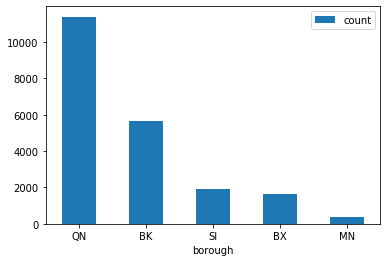

In [38]:
ax = boro_dist.plot.bar(x='borough', y='count', rot=0)